# 0. IMPORTACIONES

In [ ]:
# pip install pandas xlrd 

Importamos las principales librerías que vamos a necesitar

In [1]:
import pandas as pd                 # Pandas para dataframes
import numpy as np                  # Numpy para trabajar matrices
import re                           # Regex para trabajar patrones
import src.functions as fc          # Nuestras funciones del documento .py
import matplotlib.pyplot as plot    # matplotlib para trabajar con gráficos.

Cargamos el documento xls desde la web

In [2]:
# Cargamos el documento desde la web

url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'

data = pd.read_excel(url)

# 1. Data Recognizing
Vamos a realizar un primer vistazo a los datos para ver a qué nos enfrentamos. 

In [ ]:
data.head(5)

In [ ]:
print(data.columns) # Obtenemos los nombres de las columnas
print(data.shape )  # La tabla de datos tiene 6969 filas x 23 columnas
print(data.size)    # La tabla tiene un total de 160287 datos

Vamos a echar un vistazo a los objetos nulos que posee la tabla para ver cuántos agujeros tiene este queso de Gruyere

In [ ]:
data.info() # Nos muestra tanto el tipo de dato por columna como los datos no nulos.

In [ ]:
data.isnull().sum() # Muestra la suma de valores nulos por columna

# 2. Data Cleaning

## 2.1 Columns drop

Para limpiar los datos, vamos a proceder de arriba a abajo, viendo primero los nombres de las columnas.

In [3]:
from src.functions import * 

In [4]:
# Aplicamos nuestra función para estandarizar los títulos de columnas
data = fc.clean_labels(data)

Renombramos un par de columnas que nos quedan fuera de la función: 

In [15]:
data.rename(columns={"species_" : "species", "unnamed_11" : "death"}, inplace= True)

In [5]:
# Vamos a borrar de raíz todos los duplicados existentes
data = data.drop_duplicates()

Y ahora eliminaremos aquellas columnas que no nos aportan información o están más corruptas.
Para definir un poco cuáles van a ser estas columnas, miraremos el porcentaje valores nulos de las mismas

In [ ]:

Na_column_amount = round(data.isna().sum()*100/len(data),2) #Calculo el porcentaje de valores NaN
Na_column_amount.sort_values(ascending = False)
print(Na_column_amount)
# Species, time y age.

Como estadísticamente sería una práctica errónea intentar rellenar datos desconocidos mediante promedios, medianas o modas de una muestra donde al menos el 40% de los datos son nulos, vamos a prescindir de las columnas que no cumplan con este criterio. 

In [9]:
from src.functions import *

In [18]:
data = clean_corrupted_col(data)

# data.drop(['age', 'time', 'species', 'unnamed_21', 'unnamed_22'], axis=1, inplace=True)

Nos desharemos de las columnas que no nos proporcionan información útil

In [19]:
prueba1 = clean_unwilling_col(data)

Y proporcionaremos al usuario la posibilidad de eliminar columnas adicionales si no las necesita para que obtenga un dataframe personalizado

In [ ]:
data_user_clean= eliminar_columnas_input(data)

# Eliminaremos las mierdas que nos faltan. 

## 2.2 Filling null values

Ahora que tenemos las columnas con las que deseamos a trabajar, procedemos a rellenar los datos nulos

In [21]:
# Vamos a establecer un criterio de que aquellas filas cuya mitad o más de los datos sean nulos, vamos a eliminarlas.

data = data.dropna(thresh=(data.shape[1] - 4))

In [ ]:
# Volvemos a contar los nulos por columna

data.isnull().sum()

Vamos a sustituir todos los valores null por "unknown" para poder trabajar con algo más de precisión

In [25]:
data["year"] = data["year"].fillna('Unknown')
data["country"] = data["country"].fillna('Unknown')
data["location"] = data["location"].fillna('Unknown')
data["sex"] = data["sex"].fillna('Unknown')
data["death"] = data["death"].fillna('Unknown')

## 2.3 Deep Selected Columns cleaning

Vamos con la columna de Estados . Eliminaremos aquellos paises con menos de 15 ataques

### Eliminación estadística de datos

In [26]:
data = clean_country(data, 15)

Vamos con la columna de Estados, que borraremos aquellos que tengan menos de 16 ataques.

In [ ]:
data= clean_state(data, 16)

En cuanto a la columna de sexo, le daremos formato para que unificar el criterio de información

In [ ]:
prueba31 = clean_sex(data)
'''MIRAR SI ERROR'''

In [ ]:
data['sex']

### Columna Year

Aprovechamos que en la columna year sólo tenemos dos "unknown" para reemplazarlos por el valor promedio de la serie. 

In [35]:
data['year'] = pd.to_numeric(data['year'], errors='coerce') # Reemplazamos 'unknown' por NaN
promedio = data['year'].mean() # Calculamos el promedio de los valores numéricos (ignorando NaN)
data['year'].fillna(promedio, inplace=True) # Reemplazamos NaN por el promedio

'''algo anda mal'''

In [ ]:
# Comprobamos
pd.unique(data['year'])

In [ ]:
'''Columna Type!
#Lo vamos a añadir todo en 'Unprovoked', 'Provoked' y 'Unknown'. 
#Las inclemencias meteorologicas las cuento como 'Unprovoked'.
#Las demás, las utilizaremos como 'Unknown'

pd.unique(data_clean['Type'])
data_clean['Type'].value_counts()
data_clean['Type'] = data_clean['Type'].apply(op.Type)
pd.unique(data_clean['Type'])'''

#Lo vamos a añadir todo en 'Unprovoked', 'Provoked' y 'Unknown'. 
#Las inclemencias meteorologicas las cuento como 'Unprovoked'.
#Las demás, las utilizaremos como 'Unknown'

### Columna Country

In [ ]:
pd.unique(data['country'])

In [51]:
print(pd.unique(data['country']).size)
pd.unique(data['country'])
data['country'].value_counts()

219


country
USA                               2474
AUSTRALIA                         1451
SOUTH AFRICA                       593
NEW ZEALAND                        141
PAPUA NEW GUINEA                   136
                                  ... 
ADMIRALTY ISLANDS                    1
FEDERATED STATES OF MICRONESIA       1
RED SEA                              1
BRITISH ISLES                        1
CEYLON (SRI LANKA)                   1
Name: count, Length: 219, dtype: int64

## 3. Hypothesis

### A) Ataques por países

In [ ]:
# Creamos una nueva tabla

countries_attacks = data[(data['country'] != 'Unknow')]
data_country_attack = countries_attacks[['country','year', 'sex',]]
data_country_attack = data_country_attack.reset_index(drop=True)
data_country_attack.head(5)

In [ ]:
data_country_attack

In [54]:
prueba = data.groupby('country').size().reset_index(name= 'attacks') # Agrupar por páis
prueba = prueba.sort_values(by='attacks', ascending=False) # Ordenar de mayor a menor
print(prueba)

                            country  attacks
210                             USA     2474
14                        AUSTRALIA     1451
175                    SOUTH AFRICA      593
130                     NEW ZEALAND      141
149                PAPUA NEW GUINEA      136
..                              ...      ...
62   FEDERATED STATES OF MICRONESIA        1
67                            GABON        1
142                           OCEAN        1
141                     New Zealand        1
0                       PHILIPPINES        1

[219 rows x 2 columns]


In [46]:
#high_level = prueba['repeticiones'].max() # Valor máximo de las repeticiones / ninguno
country_attack_level = prueba.iloc[:10, :]
print(country_attack_level)


              country  repeticiones
210               USA          2474
14          AUSTRALIA          1451
175      SOUTH AFRICA           593
130       NEW ZEALAND           141
149  PAPUA NEW GUINEA           136
16            BAHAMAS           129
23             BRAZIL           119
116            MEXICO            98
92              ITALY            71
63               FIJI            66


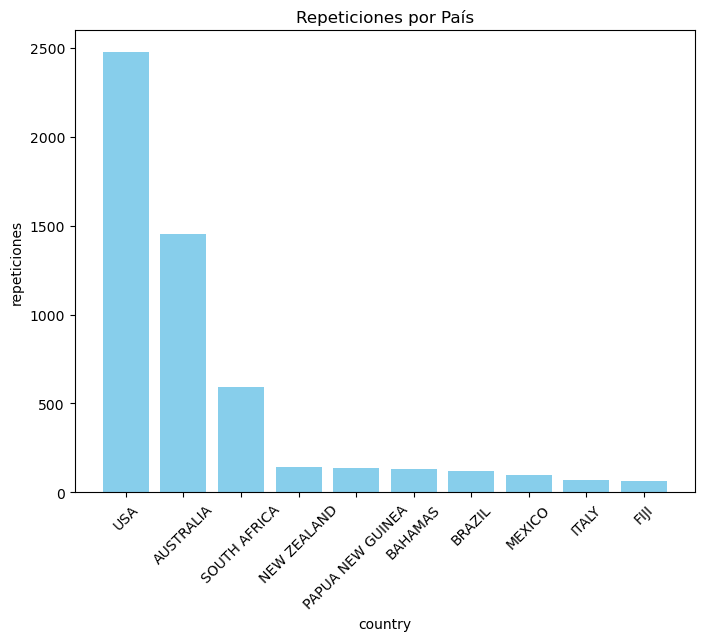

In [47]:
#Diagrama de barras. 

# Crear gráfico de barras
plot.figure(figsize=(8, 6))
plot.bar(country_attack_level['country'], country_attack_level['repeticiones'], color='skyblue')

# Añadir etiquetas y título
plot.xlabel('country')
plot.ylabel('repeticiones')
plot.title('Repeticiones por País')
plot.xticks(rotation=45)

# Mostrar gráfico
plot.show()